In [1]:
# libraries!
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import copy
import colorsys
import time


#
# If you don't have the PIL library, try installing  Pillow   in the usual manner:
#
#!pip3 install Pillow
#


#### This function will read an image file and return its pixels:

def getRGB(filename):
    """ reads a png or jpg file like 'flag.jpg' (a string)
        returns the pixels as a list-of-lists-of-lists
        this is accessible, but not fast: Use small images!
    """
    original = Image.open(filename)     # open the image
    print(f"Reading image from '{filename}':")
    print(f"  Format: {original.format}\n  Original Size: {original.size}\n  Mode: {original.mode}")
    max_dim = max(original.size)
    print(max_dim)
    MAX_DIMENSION = 2400   # edit this to allow larger images
    scale = max_dim/MAX_DIMENSION
    if scale > 1.0:
        new_size = tuple([round(x/scale) for x in original.size])
        print(f"WARNING:  New size is {new_size}")
        original = original.resize(new_size)
    else:
        print(f"Keeping original size of {original.size}")
        
    WIDTH, HEIGHT = original.size
    px = original.load()
    PIXEL_LIST = []
    for r in range(HEIGHT):
        row = []
        for c in range(WIDTH):
            row.append( px[c,r][:3] )
        PIXEL_LIST.append( row )
    return PIXEL_LIST


# wrapper for matplotlib's show function
def set_magnification(width, height, ax=None):
    """Sets the size of an image when printing in the notebook
       w, h: width, height in inches 
    """
    w = width; h = height
    if not ax: 
        ax=plt.gca()  # gets current axes
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

# a show_image function that wraps the use of set_magnification
def show_image( rgbdata, hgt_in=None, wid_in=None ):
    """ shows an image whose pixels are in rgbdata 
        note:  rgbdata is a list-of-rows-of-pixels-of-rgb values, _not_ a filename!
            use getRGB() to get this data!
        hgt_in is the desired height (in inches)
        wid_in is the desired width (in inches)
            use set_size() with these parameters
        _but_ the library will not change the aspect ratio (takes the smaller)
        by default, the hgt_in and wid_in are 5.42 in.
        (and feel free to change these!)
    """
    fig, ax = plt.subplots()               # obtains the figure and axes objects
    im = ax.imshow(rgbdata)                # this is matplotlib's call to show an image 
    if hgt_in != None and wid_in == None:
        wid_in = hgt_in
    if hgt_in != None:
        set_magnification(width=wid_in, height=hgt_in)  # matplotlib will maintain the image's aspect ratio
    ax.axis('off')                         # turns off the axes (in units of pixels)
    plt.show()                             # show the image


In [2]:
def saveRGB( PX, filename ):
    """ saves a list-of-lists-of-lists of rgb pixels (PX) where
        len(PX) == the # of rows
        len(PX[0]) == the # of columns
        len(PX[0][0]) should be 3 (rgb)
    """
    boxed_pixels = PX
    print( 'Starting to save', filename, '...' )
    H = len(PX)
    W = len(PX[0])
    im = Image.new("RGB", (W, H), "black")
    px = im.load()
    for r in range(H):
        for c in range(W):
            bp = boxed_pixels[r][c]
            t = tuple(bp)
            px[c,r] = t
    im.save( filename )
    time.sleep(0.42)   # give the filesystem some time...
    print( filename, "saved." )    

Reading image from 'project_image.JPG':
  Format: JPEG
  Original Size: (2317, 1536)
  Mode: RGB
2317
Keeping original size of (2317, 1536)


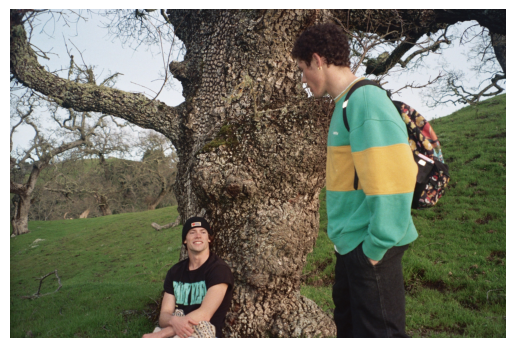

In [3]:
filename = "project_image.JPG"   # pick an image from the list above!
rgbdata = getRGB(filename)
show_image(rgbdata)    # 1 is the optional "magnification" level

In [6]:
# let's see some values!

values = getRGB("project_image.JPG")
V = values[0][0:3][:]           # first row, three columns (pixels) with each one an (r, g, b) tuple
print(f"{len(values), len(values[0])}")
print(f"Manipulate 1 LSB: {len(values)*len(values[0])*3}") # number of available bits for data hiding, sound is 2 bytes per sample
V

Reading image from 'project_image.JPG':
  Format: JPEG
  Original Size: (2317, 1536)
  Mode: RGB
2317
Keeping original size of (2317, 1536)
(1536, 2317)
Manipulate 1 LSB: 10676736


[(26, 25, 30), (29, 28, 33), (30, 31, 35)]

In [7]:
numBytes = 10676736/8 
numSamples = numBytes/2
secondsMusic = numSamples/44100
secondsMusic

15.131428571428572

In [20]:
def steganographize( image_rgb, message ):
    """Embeds a message in an image's RGB data"""
    
    num_rows = len(image_rgb) 
    num_cols = len(image_rgb[0])
    print(f"There are {num_rows} rows and {num_cols} columns\n")
    
    #
    # some helper code to convert to individual zeros and ones...
    #
    binaryMessage = ""
    for char in message:
        value = ord(char)
        binary = bin(value)[2:]
        nbits = len(binary)    # to make sure we have 8 bits...
        binary = '0'*(8-nbits) + binary
        binaryMessage += binary
    binaryMessage += '00000000000000000000000000000'
    
    ml = len(binaryMessage)
    available = num_rows*num_cols*3
    print(f"Message in binary is {binaryMessage} (with {ml//3} full pixels and {ml%3} extra values)")
    print(f"This image has {available} pixels\n")
    
    if ml > available:
        print(f"There is not enough space to encode your message here...")
        return 42
    
    new_rgb = copy.deepcopy(image_rgb)

    bi = 0    # our "bit index"
    for row in range(num_rows):
        print(f"row is {row}")
        for col in range(num_cols):
            r, g, b = image_rgb[row][col]  # get the current r, g, b 
            # here, you will want to (a) check if we're done [[ use bi and ml! ]]
            #       if we're done, then just return new_rgb     Yay!
            # nice to give a name to the next bit of the message (binaryMessage[bi])
            if bi == ml-1: # done
                return new_rgb
            #

               
            if bin(r)[-1] != binaryMessage[bi]:
                if r%2==0:
                    r += 1
                else:
                    r -= 1
            bi += 1
            
            if bi == ml-1: # done
                new_rgb[row][col] = (r,g,b)
                return new_rgb
            
            if bin(g)[-1] != binaryMessage[bi]:
                if g%2==0:
                    g += 1
                else:
                    g -= 1
            bi += 1

            if bi == ml-1: # done
                new_rgb[row][col] = (r,g,b)
                return new_rgb
            
            if bin(b)[-1] != binaryMessage[bi]:
                if b%2==0:
                    b += 1
                else:
                    b -= 1
            bi += 1

            # Then, assign back to the new_rgb:  new_rgb[row][col] = (r,g,b)
            new_rgb[row][col] = (r,g,b)
            
    return new_rgb

In [21]:
filename = "project_image.JPG"   # the image to embed the message in
message = "hello world"   # the message

image_rgb = getRGB(filename)
image_new = steganographize(image_rgb, message)

Reading image from 'project_image.JPG':
  Format: JPEG
  Original Size: (2317, 1536)
  Mode: RGB
2317
Keeping original size of (2317, 1536)
There are 1536 rows and 2317 columns

Message in binary is 011010000110010101101100011011000110111100100000011101110110111101110010011011000110010000000000000000000000000000000 (with 39 full pixels and 0 extra values)
This image has 10676736 pixels

row is 0


In [22]:
# choose a name for the image you will create
savefile = "project_image_with_message.png"   # save the _new_ image

saveRGB(image_new, savefile)

Starting to save project_image_with_message.png ...
project_image_with_message.png saved.


In [23]:
def desteganographize(image_rgb):
    """Extracts a message hidden in an image's RGB data"""
    
    num_rows = len(image_rgb) 
    num_cols = len(image_rgb[0])
    print(f"There are {num_rows} rows and {num_cols} columns\n")
    sub = ""
    message = ""
    
    for row in range(num_rows):
        print(f"row is {row}")
        for col in range(num_cols):
            pix = image_rgb[row][col]
            for channel in pix:
                binary = bin(channel)[2:]
                nbits = len(binary)    # to make sure we have 8 bits...
                binary = '0'*(8-nbits) + binary
                LSB = binary[-1]
                sub += LSB
                if len(sub) == 8:                      
                    #convert to string because we've hit 8 bits
                    sub_int = int(sub, 2)
                    print(sub_int)
                    ascii_sub = chr(sub_int)
                    #then add to message
                    message += ascii_sub
                    #then remove all bits from sub
                    if sub == '00000000':
                        return message
                    else:
                        sub = ''

In [24]:
filename = 'project_image_with_message.png'   # feel free to change this
image_rgb = getRGB(filename)
message = desteganographize(image_rgb)
print(f"message is {message}")

Reading image from 'project_image_with_message.png':
  Format: PNG
  Original Size: (2317, 1536)
  Mode: RGB
2317
Keeping original size of (2317, 1536)
There are 1536 rows and 2317 columns

row is 0
104
101
108
108
111
32
119
111
114
108
100
0
message is hello world 
